In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.linear_model
%matplotlib inline

In [2]:
data = pd.read_csv('Cars93.csv')

In [3]:
X = data[['Horsepower', 'Turn.circle', 'MPG.highway']]
Y = data['Price'].values.reshape(-1,1)

x_obs = np.array(data[['Horsepower', 'Turn.circle', 'MPG.highway']])
y_obs = np.array(data['Price'].values.reshape(-1,1))
y_sigma_obs = np.std(y_obs)
np.shape(y_obs)

(93, 1)

7.1 Estimando con Bootstrapping (como en Piratas del Caribe)

In [4]:
n_boot = 5000
beta_0 = np.ones(n_boot)
beta_1 = np.ones(n_boot)
beta_2 = np.ones(n_boot)
beta_3 = np.ones(n_boot)
r2_train = np.ones(n_boot)
r2_validation = np.ones(n_boot)

linear = sklearn.linear_model.LinearRegression()
for i in range(n_boot):
    X_train, X_validation, Y_train, Y_validation = sklearn.model_selection.train_test_split(X, Y, test_size=0.5)
    linear.fit(X_train, Y_train)
    beta_0[i] = linear.intercept_[0]
    beta_1[i] = linear.coef_[0][0]
    beta_2[i] = linear.coef_[0][1]
    beta_3[i] = linear.coef_[0][1]
    r2_train[i] = linear.score(X_train, Y_train)
    r2_validation[i] = linear.score(X_validation, Y_validation) 

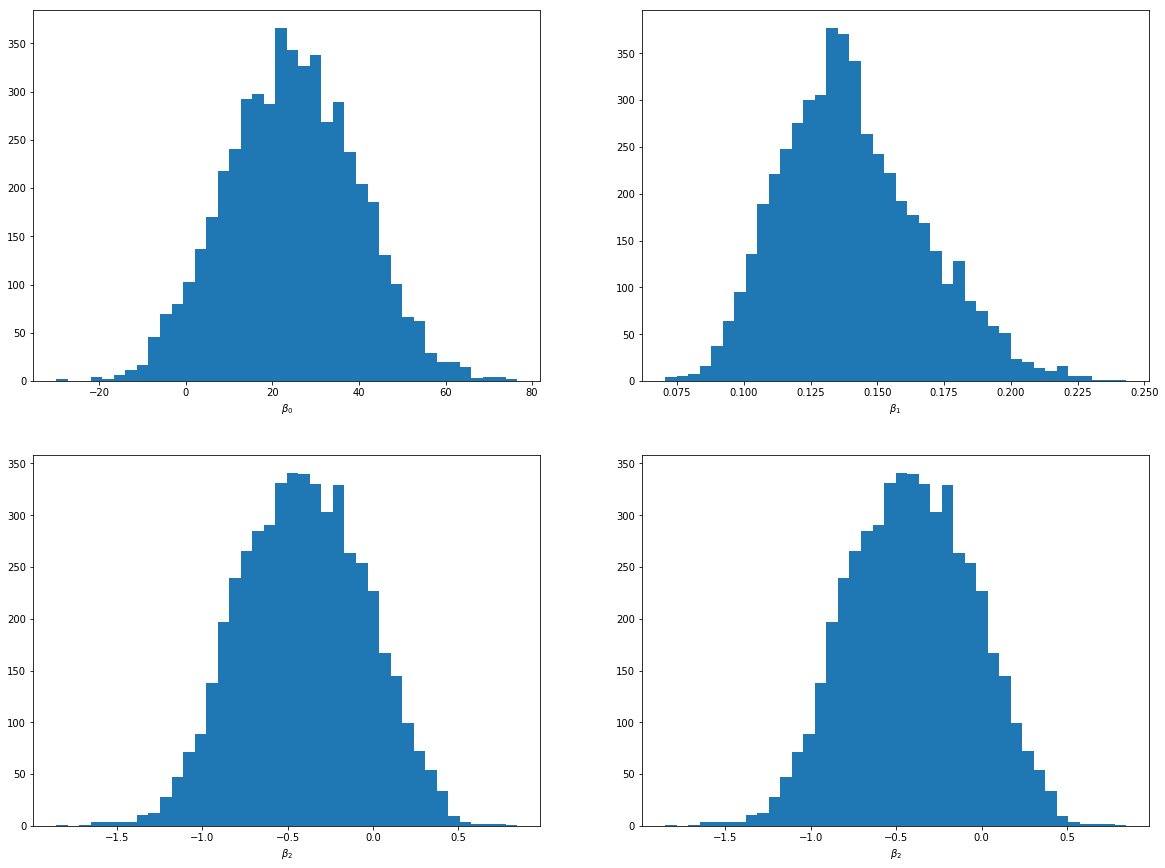

In [5]:
plt.figure(figsize=(20,15))

plt.subplot(221)
_ = plt.hist(beta_0, bins=40)
_ = plt.xlabel(r'$\beta_0$')

plt.subplot(222)
_ = plt.hist(beta_1, bins=40)
_ = plt.xlabel(r'$\beta_1$')

plt.subplot(223)
_ = plt.hist(beta_2, bins=40)
_ = plt.xlabel(r'$\beta_2$')

plt.subplot(224)
_ = plt.hist(beta_3, bins=40)
_ = plt.xlabel(r'$\beta_2$')


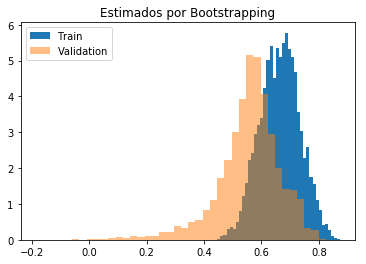

In [6]:
_ = plt.hist(r2_train, bins=40, density=True, label='Train')
_ = plt.hist(r2_validation, bins=40, alpha=0.5, density=True, label='Validation')

plt.title("Estimados por Bootstrapping")
plt.legend()

7.2  Ahora realicemos la estimacion de parametros con MCMC

In [34]:
def model(x, c):
    n_dim = len(c)
    y = np.zeros(len(x))
    y = c[0]
    for i in range(n_dim-1):
        y += c[i+1] * x[:,i]
    return y
        
def loglikelihood(x_obs, y_obs, y_sigma_obs, params):
    y_model = model(x_obs, params)
    d = -0.5 * ((y_model - y_obs)/y_sigma_obs)**2
    norm = np.sqrt(2.0 * np.pi * y_sigma_obs **2)
    return np.sum(d - np.log(norm))

def logprior(param):
    if (param[0]) < 100 and  (param[0])>(-30) and (param[2]) < 2 and  (param[1])>(0) and (param[1]) < 1 and  (param[2])>(-2) and (param[3]) < 2 and  (param[3])>(-2):
        p = 0
    else:
        p = -np.inf
    return p

In [39]:
def metropolis(x_obs, y_obs,y_sigma_obs,p, N = 100000):
    l_param = [[20,0.25,0,0]]
    sigma_param = [1,0.001,0.01,0.01]
    n_param = p
    logposterior = [0]
    for i in range(1,N):
        propuesta  = l_param[i-1] + np.random.normal(size=n_param)*sigma_param
        #print(propuesta)
        logposterior_viejo = loglikelihood(x_obs, y_obs,y_sigma_obs, l_param[i-1]) + logprior(l_param[i-1])
        logposterior_nuevo = loglikelihood(x_obs, y_obs,y_sigma_obs, propuesta) + logprior(propuesta)

        r = min(1,np.exp(logposterior_nuevo-logposterior_viejo))
        alpha = np.random.random()
        if(alpha<r):
            l_param.append(propuesta)
            logposterior.append(logposterior_nuevo)
        else:
            l_param.append(l_param[i-1])
            logposterior.append(logposterior_viejo)
    
    l_param = np.array(l_param)
    logposterior = np.array(logposterior)
    return l_param, logposterior

In [40]:
param, posterior = metropolis(x_obs, y_obs,y_sigma_obs,4)
print(np.mean(param[:,0]), np.mean(param[:,1]), np.mean(param[:,2]), np.mean(param[:,3]))

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


18.985930425694672 0.00395107511378158 -0.011892453512432878 0.014999981877548592


Comparemos claramente los histogramas obtenidos en cada uno de los ejercicios:

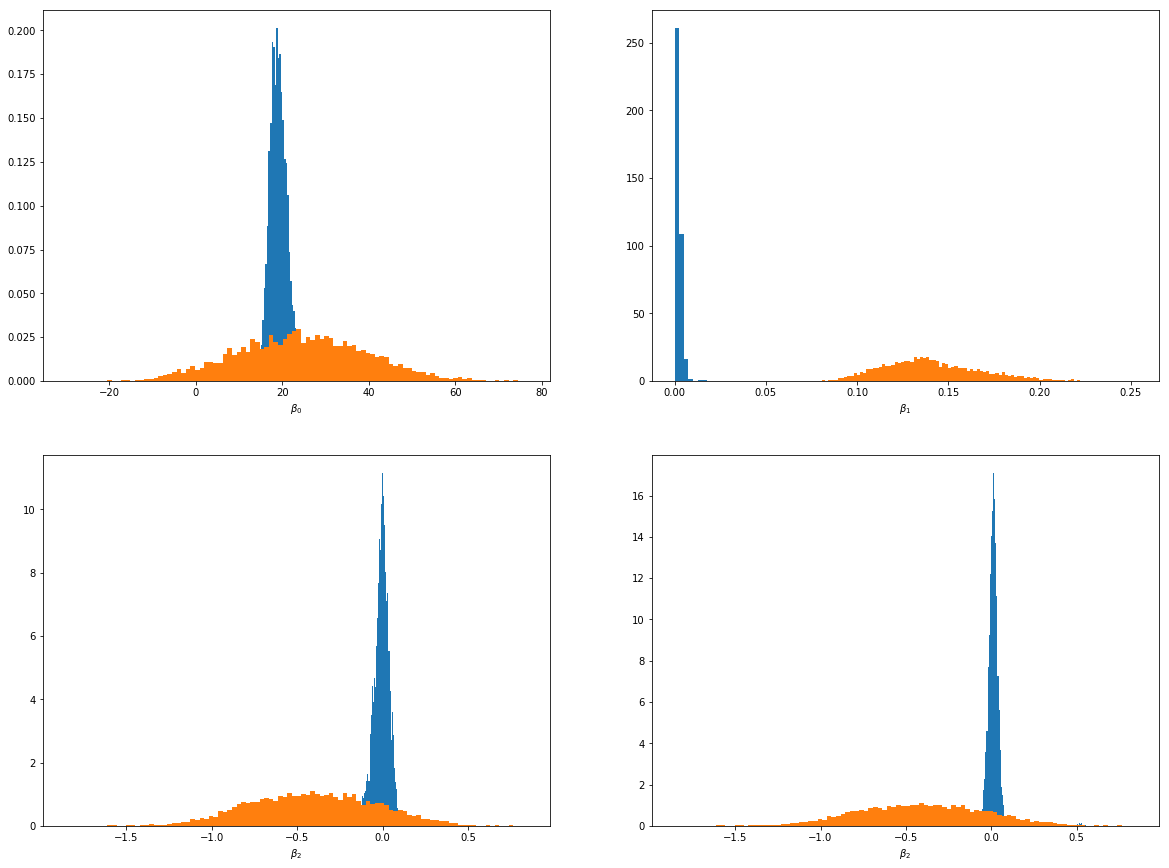

In [41]:
plt.figure(figsize=(20,15))

plt.subplot(221)
_= plt.hist(param[:,0],bins=100, density=True)
_ = plt.hist(beta_0, bins=100, density=True)
_ = plt.xlabel(r'$\beta_0$')

plt.subplot(222)
_= plt.hist(param[:,1],bins=100, density=True)
_ = plt.hist(beta_1, bins=100, density=True)
_ = plt.xlabel(r'$\beta_1$')

plt.subplot(223)
_= plt.hist(param[:,2],bins=100, density=True)
_ = plt.hist(beta_2, bins=100, density=True)
_ = plt.xlabel(r'$\beta_2$')

plt.subplot(224)
_= plt.hist(param[:,3],bins=100, density=True)
_ = plt.hist(beta_3, bins=100, density=True)
_ = plt.xlabel(r'$\beta_2$')



7.3 Construyamos el bootstrap para poder estimar la importancia de los trece parametros dados. 

In [45]:
k=['MPG.city', 'MPG.highway', 'EngineSize', 
   'Horsepower', 'RPM', 'Rev.per.mile',
   'Fuel.tank.capacity', 'Passengers', 'Length',
   'Wheelbase', 'Width', 'Turn.circle', 'Weight']
X = data[k]
Y = data['Price'].values.reshape(-1,1)
len(k)

13

In [50]:
n_boot = 500
dim = len(k)
beta = np.ones((n_boot, dim+1))
r2_train = np.ones(n_boot)
r2_validation = np.ones(n_boot)

linear = sklearn.linear_model.LinearRegression()
for i in range(n_boot):
    for j in range(dim-1):
        X_train, X_validation, Y_train, Y_validation = sklearn.model_selection.train_test_split(X, Y, test_size=0.5)
        linear.fit(X_train, Y_train)
        beta[i][0] = linear.intercept_[0]
        beta[i][j+1] = linear.coef_[0][j]
        r2_train[i] = linear.score(X_train, Y_train)
        r2_validation[i] = linear.score(X_validation, Y_validation) 

Visualizamos unos parametros para poder estar seguros de que se logro. 

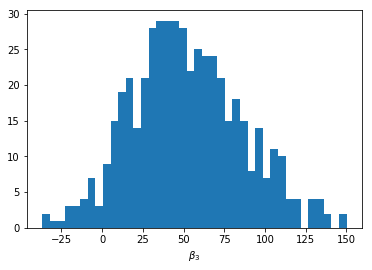

In [53]:
_ = plt.hist(beta[:,0], bins=40)
_ = plt.xlabel(r'$\beta_3$')

In [55]:
for i in range(dim):
    if (any(beta[:,i]) == 0):
        print("Beta %i se puede desestimar", i)

Podemos desestimar los parametros